In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import mw_protocol.plotting as plotting
import mw_protocol.spreading as spreading
import mw_protocol.toolbox as tb
import seaborn as sns
import datetime

In [2]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
# To change to your personal directory
script_folder = "/nfs/see-fs-01_users/eeymr/work/scripts/mw_protocol/"

# Demonstration spreading algorithm

**Objective** : To avoid high peaks in meltwater distribution here is an alogithm to spread metlwater from collection boxes to spreading regions. This is added to the waterfix to create the final spread waterfix file.
- Collect routed meltwater points (m3/s) in collection boxes and distribute them to spreading regions overlaped with the 500m land sea mask (m3/s).
- Convert waterfix (kg/m2/s) to (m3/s). Add waterfix file (with nan replaced by 0) (m3/s).
- Check conservation of flux with a flux check.

*DIRECTLY ADAPTED FROM produce_deglacHadCM3_spread.py by R F Ivanovic*

## Main method

In [4]:
# Routed meltwater map
ds_routed = xr.open_dataset(f"{script_folder}/outputs/sample_routed_discharge.nc", decode_times=False)
lon_hadcm3, lat_hadcm3 = ds_routed.longitude.values, ds_routed.latitude.values
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)

# Land-sea mask
ds_lsm = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
lsm = ds_lsm.lsm.values

# Waterfix
ds_wfix = xr.open_dataset(f"{script_folder}/data/temev.qrparm.waterfix.nc")

surface_matrix = tb.surface_matrix(lon_hadcm3, lat_hadcm3)

In [5]:
ds_spread = spreading.spreading(ds_routed, ds_lsm, ds_wfix, discharge_unit='m3/s', waterfix='GLAC-1D')

__ Spreading algorithm
____ Spreading in US_East_Coast
____ Spreading in Greenland_Arctic
____ Spreading in N_American_Arctic
____ Spreading in Gulf_of_Mexico
____ Spreading in East_Pacific
____ Spreading in Russia_Pacific
____ Spreading in LabradorSea_BaffinBay
____ Spreading in Atlantic_GreenlandIceland
____ Spreading in EastGreenland_Iceland
____ Spreading in EastIceland
____ Spreading in UK_Atlantic
____ Spreading in Eurasian_GINSeas
____ Spreading in South_Iceland
____ Spreading in Eurasian_Arctic
____ Spreading in Siberian_Arctic
____ Spreading in Mediterranean
____ Spreading in Patagonia_Atlantic
____ Spreading in Patagonia_Pacific
____ Spreading in NorthNewZealand_Pacific
____ Spreading in SouthNewZealand_Pacific
____ Spreading in Antarctica_RossSea
____ Spreading in Antarctica_AmundsenSea
____ Spreading in Antarctica_WeddellSea
____ Spreading in Antarctica_RiiserLarsonSea
____ Spreading in Antarctica_DavisSea

Spreading of water didn't work.

Checking the mean flux (from m3/s 

In [6]:
ds_spread

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 5)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    discharge  (t, latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:                SPREAD MELTWATER DISCHARGE
    start_year:           -26000
    end_year:             -25600
    step:                 100
    mode_lon:             double
    mode_shape:           cross
    running_mean_period:  0
    ice_sheet:            GLAC-1D
    waterfix:             GLAC-1D
    history:              Created 2022-12-09 14:52:14.023401 by Yvan Romé

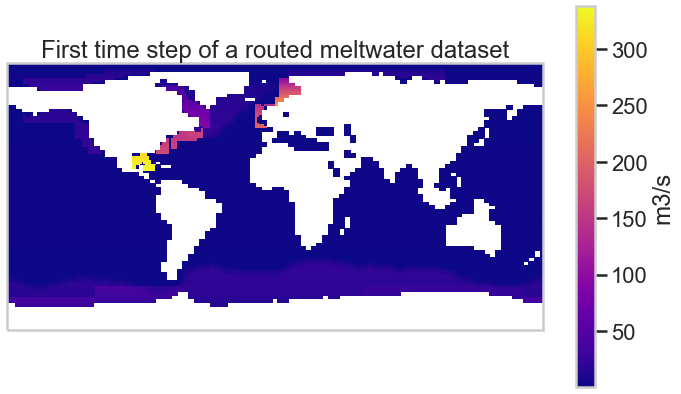

In [7]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(12,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, tb.masking(ds_spread.discharge[0], lsm), 
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

In [8]:
# We can save this intermediate output as data for the other demonstration notebooks.

# ds_spread.to_netcdf(f"{script_folder}/outputs/sample_spread_discharge.nc")

## Inputs

**Land Sea Mask :** Surface and 500m land sea mask.

Text(0.5, 1.0, 'Land sea mask - 500m')

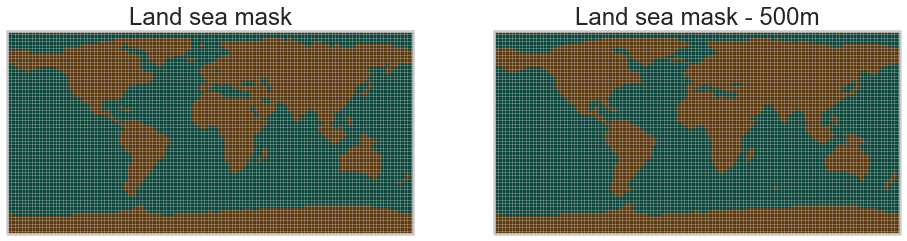

In [9]:
ds_lsm = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
lon_lsm, lat_lsm, depth, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.depthdepth.values, ds_lsm.lsm.values
lon_lsm_b, lat_lsm_b = tb.create_coordinate_edges(lon_lsm), tb.create_coordinate_edges(lat_lsm)

masked = np.copy(lsm)  # land mask True (1) on land
depthm = np.ma.masked_less(depth, 500.0)  # mask areas shallower than 500m
masked_500m = np.copy(depthm.mask) + masked  # create binary mask from depth data

projection_map = ccrs.PlateCarree()

figMap,(axMask, ax500) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))
axMask.pcolormesh(lon_lsm_b, lat_lsm_b, masked, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMask.set_title("Land sea mask")
ax500.pcolormesh(lon_lsm_b, lat_lsm_b, masked_500m, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
ax500.set_title("Land sea mask - 500m")

In [10]:
# ds_lsm_ice6g = xr.open_dataset(f"{script_folder}/data/ice6g.omask.nc")
# lsm_ice6g = ds_lsm_ice6g.lsm.values
# depthm_ice6g = np.ma.masked_less(ds_lsm_ice6g.depthdepth.values, 500.0)  # mask areas shallower than 500m
# masked_ice6g = np.copy(lsm_ice6g)  # land mask True (1) on land
# masked_500m_ice6g = np.copy(depthm_ice6g.mask) + masked_ice6g  # create binary mask from depth data

**Routed mask :** 3 dimensional routed poitnlike meltwater mask (routing algorithm outcome). Because the saving algorithm deal with a flux per surface, we also need to convert the meltwater_discharge *(kg/m2/s -> m3/s)*.

In [11]:
ds_routed = xr.open_dataset(f"{script_folder}/outputs/sample_routed_discharge.nc", decode_times=False)
lon_hadcm3, lat_hadcm3 = ds_routed.longitude.values, ds_routed.latitude.values
lon_hadcm3_b, lat_hadcm3_b = tb.create_coordinate_edges(lon_hadcm3), tb.create_coordinate_edges(lat_hadcm3)
routed_discharge = ds_routed.discharge

# surface_matrix = tb.surface_matrix(lon_hadcm3, lat_hadcm3)
# discharge = np.where(np.isnan(discharge), 0, discharge / 1000 * surface_matrix)

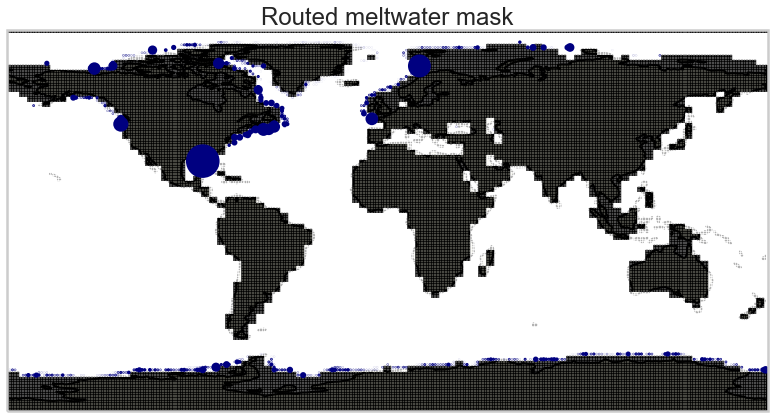

In [12]:
projection_map = ccrs.PlateCarree()

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="binary", alpha=0.7)

x,y,s = plotting.scatter_mask(routed_discharge[-1])
axMap.scatter(lon_hadcm3[x], lat_hadcm3[y], transform=ccrs.PlateCarree(), s=10*s, color="navy")
axMap.set_global()
axMap.set_title("Routed meltwater mask")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

In [13]:
print(f"Total flux : {np.nansum([0])*10**(-6)} Sv")

Total flux : 0.0 Sv


**Waterfix** : 2 dimenstion (lat*lon) hadcm3 meltwater discharge

In [14]:
ds_wfix = xr.open_dataset(f"{script_folder}/data/temev.qrparm.waterfix.nc")

lon_wfix, lat_wfix = ds_wfix.longitude.values[:-2], ds_wfix.latitude.values
lon_wfix_b, lat_wfix_b = tb.create_coordinate_edges(lon_wfix), lat_wfix
wfix = ds_wfix.field672.isel(depth=0).isel(t=0)[:, :-2]

ds_wfix

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 144, longitude: 290, t: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 357.5 358.8 360.0 361.2
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * depth      (depth) float32 5.0
  * t          (t) object 1800-12-01 00:00:00
Data variables:
    field672   (t, depth, latitude, longitude) float32 ...
Attributes:
    history:  Thu Jan 18 08:19:59 GMT 2018 - CONVSH V1.91 16-February-2006

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


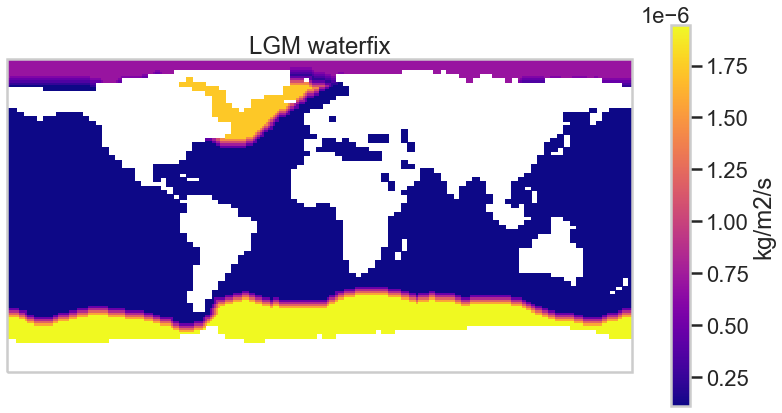

In [15]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_wfix_b, lat_wfix_b, wfix, cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

## Step 1 : Generate collection and spreading zones

### Defining collection boxes

In [16]:
cb = spreading.generate_collection_boxes()
cb

{'USECoast1': None ocean cells in the box,
 'USECoast2': None ocean cells in the box,
 'USECoast3': None ocean cells in the box,
 'USECoast4': None ocean cells in the box,
 'USECoast5': None ocean cells in the box,
 'USECoast6': None ocean cells in the box,
 'GrArc1': None ocean cells in the box,
 'NAMArc1': None ocean cells in the box,
 'NAMArc2': None ocean cells in the box,
 'NAMArc3': None ocean cells in the box,
 'NAMArc4': None ocean cells in the box,
 'NAMArc5': None ocean cells in the box,
 'NWTerr1': None ocean cells in the box,
 'NWTerr2': None ocean cells in the box,
 'GrLakes1': None ocean cells in the box,
 'GoM1': None ocean cells in the box,
 'EPac1': None ocean cells in the box,
 'EPac2': None ocean cells in the box,
 'EPac3': None ocean cells in the box,
 'EPac4': None ocean cells in the box,
 'EPac5': None ocean cells in the box,
 'RussPac1': None ocean cells in the box,
 'BafLab1': None ocean cells in the box,
 'BafLab2': None ocean cells in the box,
 'BafLab3': None

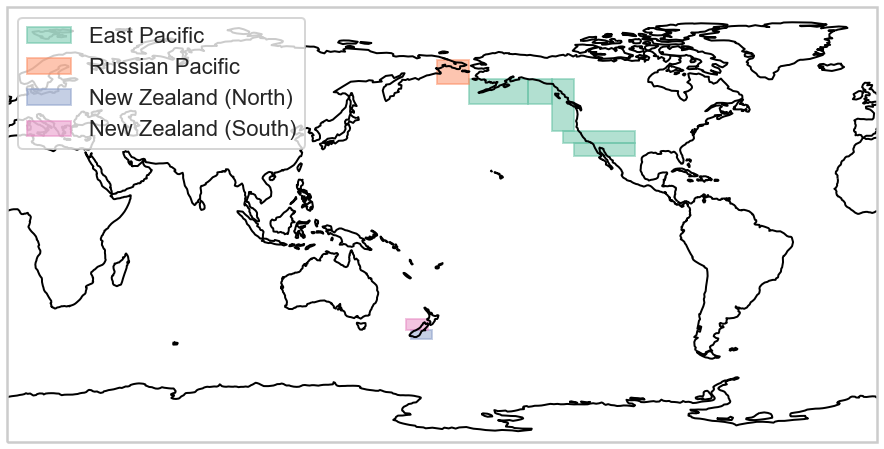

In [17]:
# PACIFIC

projection_map = ccrs.PlateCarree(central_longitude=180.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

# c_list = plt.cm.turbo(np.linspace(0.05, 0.95, 4))
c_list = plt.cm.Set2


# East Pacific
for box in ["EPac1", "EPac2", "EPac3", "EPac4", "EPac5"]:
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(0), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree())
axMap.fill([],[], color=c_list(0), linestyle = "-", alpha=0.5, label="East Pacific")

# Russia Pacific
axMap.fill(cb["RussPac1"].cycle_box()[0], cb["RussPac1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree(), label="Russian Pacific")

# New Zealand (South)
axMap.fill(cb["SNZPac1"].cycle_box()[0], cb["SNZPac1"].cycle_box()[1], 
           color=c_list(2), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree(), label="New Zealand (North)")

# New Zealand (North)
axMap.fill(cb["NNZPac1"].cycle_box()[0], cb["NNZPac1"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha=0.5, transform=ccrs.PlateCarree(), label="New Zealand (South)")

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper left")

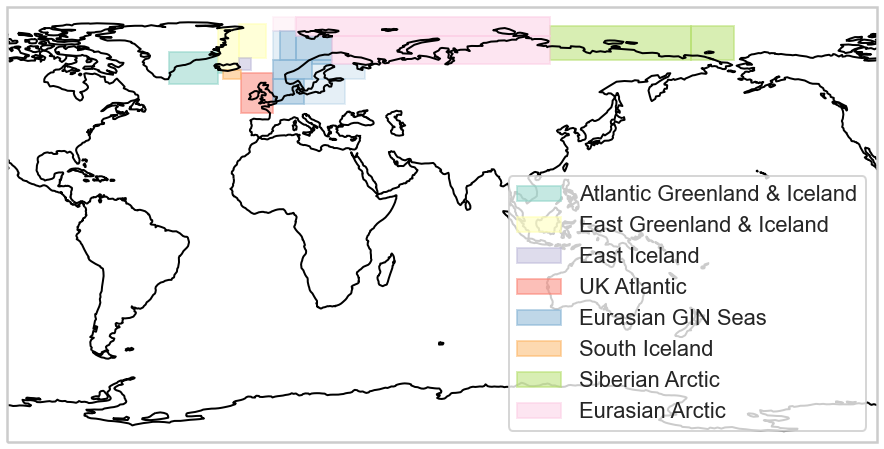

In [18]:
# ARCTIC AND GIN SEAS

projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

# c_list = plt.cm.turbo(np.linspace(0.05, 0.95, 4))
c_list = plt.cm.Set3


# Atlantic Greenland Iceland
axMap.fill(cb["AtlGr1"].cycle_box()[0], cb["AtlGr1"].cycle_box()[1], 
           color=c_list(0), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Atlantic Greenland & Iceland")
axMap.fill(cb["AtlGr2"].cycle_box()[0], cb["AtlGr2"].cycle_box()[1], 
           color=c_list(0), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# E Greenland & Iceland
axMap.fill(cb["EGrIce1"].cycle_box()[0], cb["EGrIce1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="East Greenland & Iceland")
axMap.fill(cb["EGrIce2"].cycle_box()[0], cb["EGrIce2"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# E Iceland
axMap.fill(cb["EIceland1"].cycle_box()[0], cb["EIceland1"].cycle_box()[1], 
           color=c_list(2), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="East Iceland")

# UK Atlantic
axMap.fill(cb["UKAtl1"].cycle_box()[0], cb["UKAtl1"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="UK Atlantic")

# Eurasian GIN Seas
for box in ["EurGIN1", "EurGIN2", "EurGIN3", "EurGIN4", "EurGIN5"] :
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
for box in ["EurGIN6", "Baltic1", "Baltic2"]:
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill([], [], color=c_list(4), linestyle = "-", alpha = 0.5, label="Eurasian GIN Seas")

# South Iceland
axMap.fill(cb["SIceland1"].cycle_box()[0], cb["SIceland1"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="South Iceland")

# Siberian Arctic
axMap.fill(cb["SibArc1"].cycle_box()[0], cb["SibArc1"].cycle_box()[1], 
           color=c_list(6), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Siberian Arctic")
axMap.fill(cb["SibArc2"].cycle_box()[0], cb["SibArc2"].cycle_box()[1], 
           color=c_list(6), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# Eurasian Arctic
axMap.fill(cb["EurArc1"].cycle_box()[0], cb["EurArc1"].cycle_box()[1], 
           color=c_list(7), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Eurasian Arctic")
axMap.fill(cb["EurArc2"].cycle_box()[0], cb["EurArc2"].cycle_box()[1], 
           color=c_list(7), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["EurArc3"].cycle_box()[0], cb["EurArc3"].cycle_box()[1], 
           color=c_list(7), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="lower right")

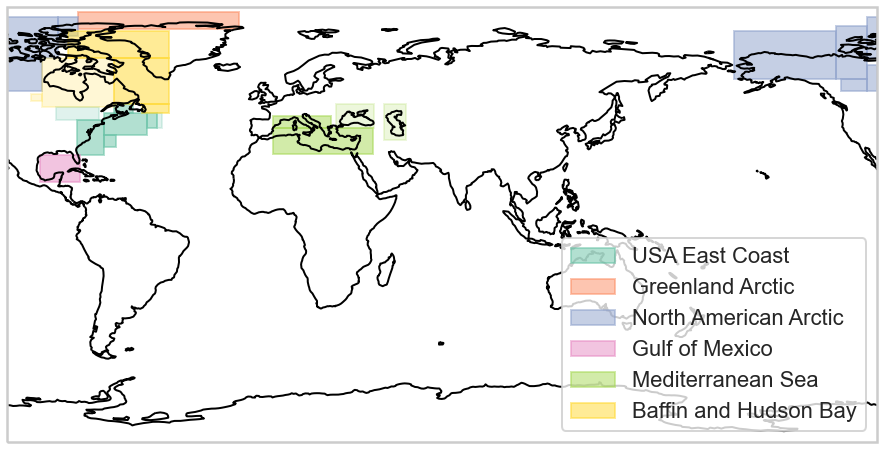

In [19]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

c_list = plt.cm.Set2

## NORTH ATLANTIC

# USA East Coast
for box in ["USECoast1", "USECoast2", "USECoast3", "USECoast4", "USECoast5"]:
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(0), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill([], [], color=c_list(0), linestyle = "-", alpha = 0.5, label="USA East Coast")
for box in ["USECoast6", "GrLakes1"]:
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(0), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())


# Greenland Arctic
axMap.fill(cb["GrArc1"].cycle_box()[0], cb["GrArc1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Greenland Arctic")

# North American Arctic
for box in ["NAMArc1", "NAMArc2", "NAMArc3", "NAMArc4", "NAMArc5", "NWTerr1", "NWTerr2"]:
    axMap.fill(cb[box].cycle_box()[0], cb[box].cycle_box()[1], 
               color=c_list(2), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill([], [], color=c_list(2), linestyle = "-", alpha = 0.5, label="North American Arctic")

# Gulf of Mexico
axMap.fill(cb["GoM1"].cycle_box()[0], cb["GoM1"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Gulf of Mexico")

# Mediterranean
axMap.fill(cb["Med1"].cycle_box()[0], cb["Med1"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Mediterranean Sea")
axMap.fill(cb["Med2"].cycle_box()[0], cb["Med2"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["BlckSea1"].cycle_box()[0], cb["BlckSea1"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["CaspSea1"].cycle_box()[0], cb["CaspSea1"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

# Labrador Sea & Baffin Bay
axMap.fill(cb["BafLab1"].cycle_box()[0], cb["BafLab1"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Baffin and Hudson Bay")
axMap.fill(cb["BafLab2"].cycle_box()[0], cb["BafLab2"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["BafLab3"].cycle_box()[0], cb["BafLab3"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())
axMap.fill(cb["HudBay1"].cycle_box()[0], cb["HudBay1"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())
axMap.fill(cb["HudBay2"].cycle_box()[0], cb["HudBay2"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.2, transform=ccrs.PlateCarree())

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="lower right")

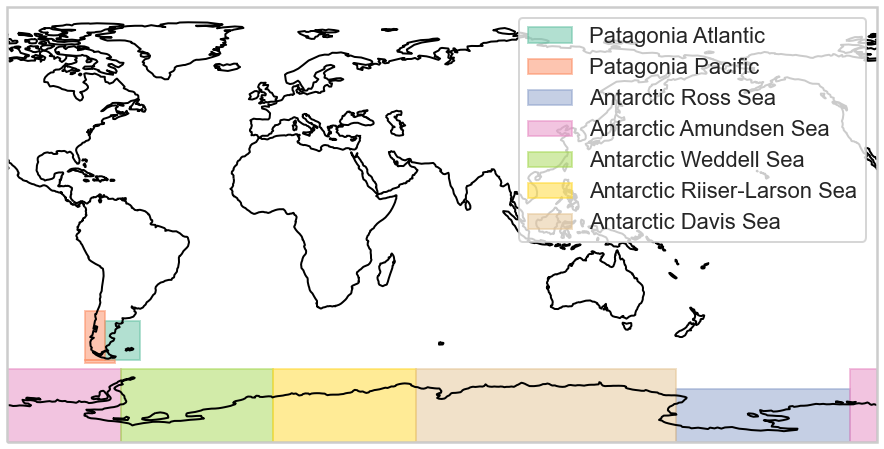

In [20]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

c_list = plt.cm.Set2

## ANTARCTICA


# Patagonia Atlantic
axMap.fill(cb["PatAtl1"].cycle_box()[0], cb["PatAtl1"].cycle_box()[1], 
           color=c_list(0), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Patagonia Atlantic")

# Patagonia Pacific
axMap.fill(cb["PatPac1"].cycle_box()[0], cb["PatPac1"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Patagonia Pacific")
axMap.fill(cb["PatPac2"].cycle_box()[0], cb["PatPac2"].cycle_box()[1], 
           color=c_list(1), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree())

# Antarctic Ross Sea
axMap.fill(cb["AARos1"].cycle_box()[0], cb["AARos1"].cycle_box()[1], 
           color=c_list(2), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Ross Sea")

# Antarctic Amundsen Sea
axMap.fill(cb["AAAmund"].cycle_box()[0], cb["AAAmund"].cycle_box()[1], 
           color=c_list(3), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Amundsen Sea")

# Antarctic Weddell Sea
axMap.fill(cb["AAWeddell"].cycle_box()[0], cb["AAWeddell"].cycle_box()[1], 
           color=c_list(4), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Weddell Sea")

# Antarctic Riiser-Larson Sea
axMap.fill(cb["AARiiLar"].cycle_box()[0], cb["AARiiLar"].cycle_box()[1], 
           color=c_list(5), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Riiser-Larson Sea")

# Antarctic Davis Sea
axMap.fill(cb["AADavis"].cycle_box()[0], cb["AADavis"].cycle_box()[1], 
           color=c_list(6), linestyle = "-", alpha = 0.5, transform=ccrs.PlateCarree(), label="Antarctic Davis Sea")

axMap.set_global()
axMap.coastlines()
axMap.legend(loc="upper right")

### Defining spreading regions

In [21]:
lat, lon = spreading.LatAxis(lat_wfix[:]), spreading.LonAxis(lon_wfix[:])
umgrid = spreading.Grid(lat, lon)

sr = spreading.generate_spreading_regions(cb, umgrid, masked, masked_500m)
# sr_ice6g = spreading.generate_spreading_regions(cb, umgrid, masked_ice6g, masked_500m_ice6g)

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


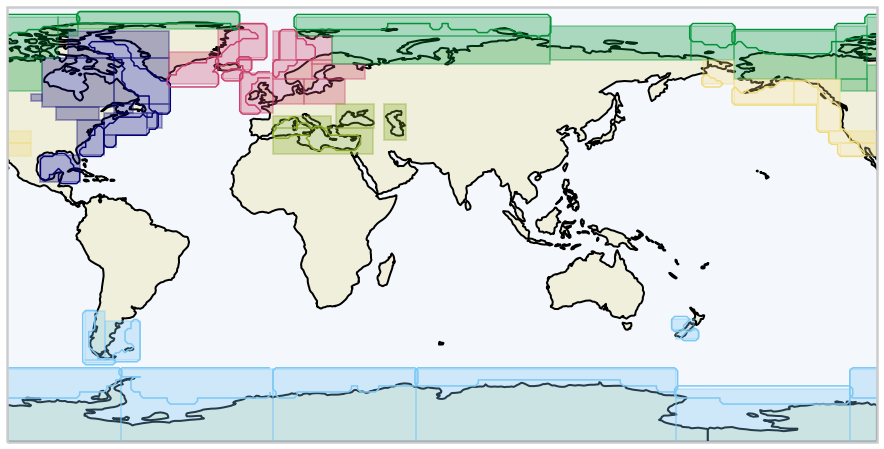

In [22]:
projection_map = ccrs.PlateCarree(central_longitude=70.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))

colors_region = {'elwg': 'xkcd:deep blue', 'gin':'xkcd:dark pink', 'med':'xkcd:avocado green', 'arc':'xkcd:kelley green', 
                'so':'xkcd:lightblue', 'wl':'xkcd:sandy', 'tot':'xkcd:black'}

# COLLECTION BOXES

# East Laurentide and West Greenland

axMap.fill(cb['USECoast1'].cycle_box()[0], cb['USECoast1'].cycle_box()[1], color=colors_region['elwg'],
           linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="East Laurentide and West Greenland")
for region in ['USECoast2', 'USECoast3', 'USECoast4', 'USECoast5', 'USECoast6', 'GrLakes1', 'GoM1', 'BafLab1',
               'BafLab2', 'BafLab3', 'HudBay1', 'HudBay2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['elwg'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())

# GIN seas

axMap.fill(cb['AtlGr1'].cycle_box()[0], cb['AtlGr1'].cycle_box()[1], color=colors_region['gin'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="GIN seas")
for region in ['EGrIce1', 'EGrIce2', 'EIceland1', 'SIceland1', 'UKAtl1', 'EurGIN1', 'EurGIN2', 'EurGIN3', 'EurGIN4',
               'EurGIN5', 'EurGIN6', 'Baltic1', 'Baltic2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['gin'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())
    
# Arctic

axMap.fill(cb['GrArc1'].cycle_box()[0], cb['GrArc1'].cycle_box()[1], color=colors_region['arc'], linestyle = "-",
           alpha=0.3, transform=ccrs.PlateCarree(), label="Arctic")
for region in ['NAMArc1', 'NAMArc2', 'NAMArc3', 'NAMArc4', 'NAMArc5', 'NWTerr1', 'NWTerr2', 'SibArc1',
               'SibArc2', 'EurArc1', 'EurArc2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['arc'], linestyle = "-", 
               alpha=0.3, transform=ccrs.PlateCarree())

# Southern ocean

axMap.fill(cb['PatAtl1'].cycle_box()[0], cb['PatAtl1'].cycle_box()[1], color=colors_region['so'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="Southern Ocean")
for region in ['PatPac1', 'PatPac2', 'AARos1', 'AAAmund', 'AAWeddell', 'AARiiLar', 'AADavis', 'SNZPac1', 'NNZPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['so'], linestyle = "-",
               alpha=0.3, transform=ccrs.PlateCarree())

# Pacific

axMap.fill(cb['EPac1'].cycle_box()[0], cb['EPac1'].cycle_box()[1], color=colors_region['wl'], linestyle = "-", 
           alpha=0.3, transform=ccrs.PlateCarree(), label="Pacific")
for region in ['EPac2', 'EPac3', 'EPac4', 'EPac5', 'RussPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['wl'], linestyle = "-", 
               alpha=0.3, transform=ccrs.PlateCarree())

# Mediterannean Sea

axMap.fill(cb['Med1'].cycle_box()[0], cb['Med1'].cycle_box()[1], color=colors_region['med'], linestyle = "-", alpha=0.3,
           transform=ccrs.PlateCarree(), label="Mediterranean Sea")
for region in ['Med2', 'BlckSea1', 'CaspSea1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color=colors_region['med'], linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

    
# SPREADING REGIONDS

for region in sr:
    if region['name'] in ['US_East_Coast', 'Gulf_of_Mexico', 'LabradorSea_BaffinBay']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors=colors_region['elwg'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Greenland_Arctic', 'N_American_Arctic', 'Eurasian_Arctic', 'Siberian_Arctic']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['arc'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['East_Pacific', 'Russia_Pacific']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['wl'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Atlantic_GreenlandIceland', 'EastGreenland_Iceland', 'EastIceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['gin'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['UK_Atlantic', 'Eurasian_GINSeas', 'South_Iceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['gin'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Mediterranean']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors=colors_region['med'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Patagonia_Atlantic', 'Patagonia_Pacific', 'NorthNewZealand_Pacific', 'SouthNewZealand_Pacific', 'Antarctica_RossSea', 'Antarctica_AmundsenSea', 'Antarctica_WeddellSea', 'Antarctica_RiiserLarsonSea', 'Antarctica_DavisSea']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors=colors_region['so'], transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)

axMap.set_global()
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axMap.add_feature(cartopy.feature.OCEAN, zorder=-1, edgecolor='black', lw=0, alpha=0.1)


## Step 2 - Spread the collected freshwater in the spreading zones

In [23]:
spread_discharge = spreading.spreading_method(routed_discharge, sr, tb.surface_matrix(lon_lsm, lat_lsm))

____ Spreading in US_East_Coast
____ Spreading in Greenland_Arctic
____ Spreading in N_American_Arctic
____ Spreading in Gulf_of_Mexico
____ Spreading in East_Pacific
____ Spreading in Russia_Pacific
____ Spreading in LabradorSea_BaffinBay
____ Spreading in Atlantic_GreenlandIceland
____ Spreading in EastGreenland_Iceland
____ Spreading in EastIceland
____ Spreading in UK_Atlantic
____ Spreading in Eurasian_GINSeas
____ Spreading in South_Iceland
____ Spreading in Eurasian_Arctic
____ Spreading in Siberian_Arctic
____ Spreading in Mediterranean
____ Spreading in Patagonia_Atlantic
____ Spreading in Patagonia_Pacific
____ Spreading in NorthNewZealand_Pacific
____ Spreading in SouthNewZealand_Pacific
____ Spreading in Antarctica_RossSea
____ Spreading in Antarctica_AmundsenSea
____ Spreading in Antarctica_WeddellSea
____ Spreading in Antarctica_RiiserLarsonSea
____ Spreading in Antarctica_DavisSea


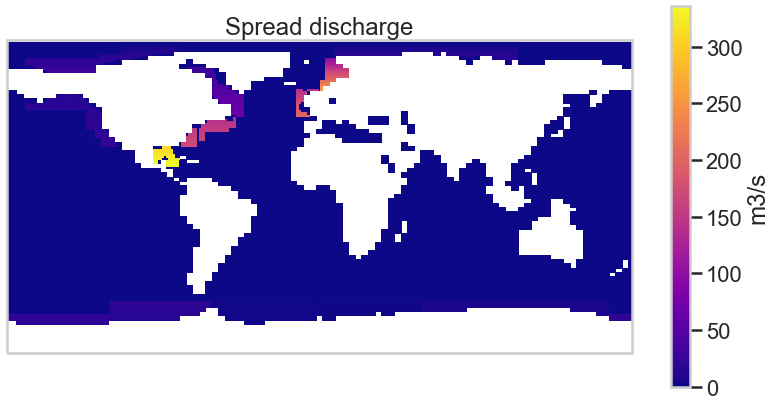

In [24]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_lsm_b, lat_lsm_b, tb.masking(spread_discharge[0], lsm),
                        cmap='plasma', transform=ccrs.PlateCarree())

axMap.set_global()
axMap.set_title("Spread discharge")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

In [25]:
print(f"Total flux : {np.nansum(spread_discharge[0])*10**(-6)} Sv")

Total flux : 0.1068379500286496 Sv


## Step 3 : Add waterfix to the spread mask

In [26]:
wfix_3d = spreading.convert_waterfix(wfix, spread_discharge, tb.surface_matrix(lon_lsm, lat_lsm))
discharge_total = spread_discharge + wfix_3d

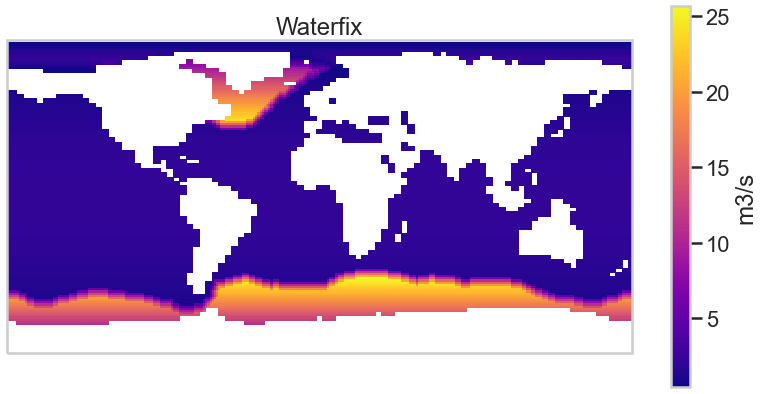

In [27]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, tb.masking(wfix_3d[0], lsm),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("Waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

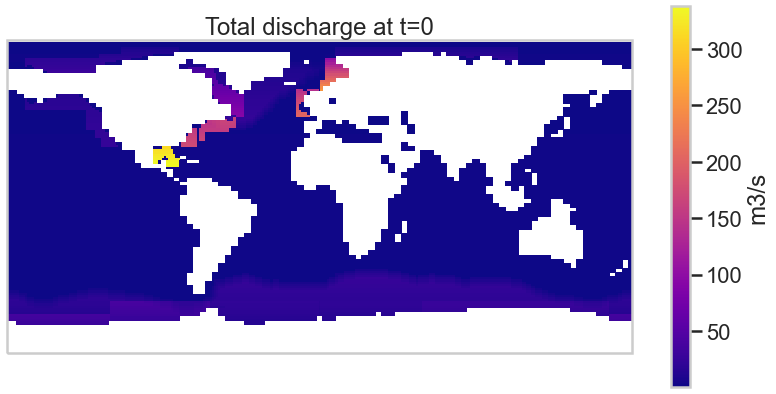

In [28]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, tb.masking(discharge_total[0], lsm),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("Total discharge at t=0")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

## Step 4 - Flux check

Flux check is used to verify the spreading between a routed and a spread array. It is already implemented in the spreading main method but can also be used a posteriori to vcheck the coupling between a routed and a spread file. For it to work, the mask of saved qfiles should be removed.

In [29]:
# Add a time dimension to the waterfix and convert it to m3/s

spread_mw = spread_discharge - wfix_3d
discharge_others = spreading.get_discharge_others(routed_discharge.values, sr)

spreading.flux_check(routed_discharge.values, spread_discharge, discharge_total, discharge_others, wfix_3d)


Spreading of water didn't work.

Checking the mean flux (from m3/s to Sv, 0.1% percent error).
[1] Initial flux (Sv): 0.1305
[2] Initial waterfix (Sv): 0.1125
[3] Initial flux + waterfix (Sv): 0.2430
[4] Spread flux (Sv): 0.1299
[5] Other zones flux (Sv): 0.0006
[6] Final waterfix (Sv): 0.1125
[7] Final flux  (Sv): 0.2424 

Initial fluxes : [3] = [1] + [2]: True
Final fluxes : [7] = [4] + [5] + [6]: True
Success of the algorithm : [1] = [4] + [5]: True


## Respreading method

In [30]:
ds_lsm_ice6g = xr.open_dataset(f"{script_folder}/data/ice6g.omask.nc")
lsm_ice6g = ds_lsm_ice6g.lsm.values
depthm_ice6g = np.ma.masked_less(ds_lsm_ice6g.depthdepth.values, 500.0)  # mask areas shallower than 500m
masked_ice6g = np.copy(lsm_ice6g)  # land mask True (1) on land
masked_500m_ice6g = np.copy(depthm_ice6g.mask) + masked_ice6g  # create binary mask from depth data

ds_lsm_glac = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
lsm_glac = ds_lsm_glac.lsm.values
depthm_glac = np.ma.masked_less(ds_lsm_glac.depthdepth.values, 500.0)  # mask areas shallower than 500m
masked_glac = np.copy(lsm_glac)  # land mask True (1) on land
masked_500m_glac = np.copy(depthm_glac.mask) + masked_glac  # create binary mask from depth data

In [31]:
ds_wfix = xr.open_dataset(f"{script_folder}/data/temev.qrparm.waterfix.nc")

lon_wfix, lat_wfix = ds_wfix.longitude.values[:-2], ds_wfix.latitude.values
lat, lon = spreading.LatAxis(lat_wfix[:]), spreading.LonAxis(lon_wfix[:])
umgrid = spreading.Grid(lat, lon)

cb = spreading.generate_collection_boxes()
sr_ice6g = spreading.generate_spreading_regions(cb, umgrid, masked_ice6g, masked_500m_ice6g)
sr_glac = spreading.generate_spreading_regions(cb, umgrid, masked_glac, masked_500m_glac)

A simple way to respread meltwater on a different land sea mask is to use the spread discharge without the waterfix as an input to the spreading algorithm.

In [32]:
ds_spread_ini = xr.open_dataset(f"{script_folder}/outputs/sample_spread_discharge.nc", decode_times=False)
discharge_ini = ds_spread_ini.discharge

ds_lsm_glac = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
ds_lsm_ice6g = xr.open_dataset(f"{script_folder}/data/ice6g.omask.nc")
lon_lsm, lat_lsm = ds_lsm_glac.longitude.values, ds_lsm_glac.latitude.values

ds_wfix_glac = xr.open_dataset(f"{script_folder}/data/temev.qrparm.waterfix.nc")
wfix_glac = ds_wfix_glac.field672.isel(depth=0).isel(t=0).values[:, :-2]
wfix_glac_3d = spreading.convert_waterfix(wfix_glac, ds_spread_ini.discharge, tb.surface_matrix(lon_lsm, lat_lsm))
lon_wfix, lat_wfix = ds_wfix_glac.longitude.values[:-2], ds_wfix_glac.latitude.values

ds_wfix_ice6g = xr.open_dataset(f"{script_folder}/data/teadv3.qrparm.waterfix.nc").rename({'unspecified':'depth'})
wfix_ice6g = ds_wfix_ice6g.field672.isel(depth=0).isel(t=0).values[:, :-2]
wfix_ice6g_3d = spreading.convert_waterfix(wfix_ice6g, ds_spread_ini.discharge, tb.surface_matrix(lon_lsm, lat_lsm))

Changing the waterfix from GLAC to ICE6G. There is something happening to the backgoud value of the waterfix.

In [33]:
ds_spread_out = spreading.respreading(ds_spread_ini, ds_lsm_glac, ds_wfix_glac, ds_lsm_ice6g, ds_wfix_ice6g, discharge_unit='m3/s', waterfix='ICE-6G')
ds_spread_out

__ Respreading algorithm
____ Spreading in US_East_Coast
____ Spreading in Greenland_Arctic
____ Spreading in N_American_Arctic
____ Spreading in Gulf_of_Mexico
____ Spreading in East_Pacific
____ Spreading in Russia_Pacific
____ Spreading in LabradorSea_BaffinBay
____ Spreading in Atlantic_GreenlandIceland
____ Spreading in EastGreenland_Iceland
____ Spreading in EastIceland
____ Spreading in UK_Atlantic
____ Spreading in Eurasian_GINSeas
____ Spreading in South_Iceland
____ Spreading in Eurasian_Arctic
____ Spreading in Siberian_Arctic
____ Spreading in Mediterranean
____ Spreading in Patagonia_Atlantic
____ Spreading in Patagonia_Pacific
____ Spreading in NorthNewZealand_Pacific
____ Spreading in SouthNewZealand_Pacific
____ Spreading in Antarctica_RossSea
____ Spreading in Antarctica_AmundsenSea
____ Spreading in Antarctica_WeddellSea
____ Spreading in Antarctica_RiiserLarsonSea
____ Spreading in Antarctica_DavisSea
Spreading of water succeded

Checking the mean flux (from m3/s to 

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 5)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    discharge  (t, latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:                RESPREAD MELTWATER DISCHARGE
    start_year:           -26000
    end_year:             -25600
    step:                 100
    mode_lon:             double
    mode_shape:           cross
    running_mean_period:  0
    ice_sheet:            GLAC-1D
    waterfix:             ICE-6G
    history:              Created 2022-12-09 14:52:53.771444 by Yvan Romé

In [34]:
# FLUX CHECK
n_t = len(ds_spread_ini.discharge)
print(f"Initial discharge flux : {np.sum(ds_spread_ini.discharge.values)/n_t*10**-6:.3f} Sv")
print(f"Initial discharge flux without waterfix (GLAC-1D): {np.sum((ds_spread_ini.discharge-wfix_glac_3d).values/n_t*10**-6):.3f} Sv")
print(f"Final discharge flux: {np.sum(ds_spread_out.discharge.values/n_t*10**-6):.3f} Sv")
print(f"Final discharge flux without waterfix (ICE6G): {np.sum((ds_spread_out.discharge-wfix_ice6g_3d).values/n_t*10**-6):.3f} Sv")

Initial discharge flux : 0.242 Sv
Initial discharge flux without waterfix (GLAC-1D): 0.130 Sv
Final discharge flux: 0.260 Sv
Final discharge flux without waterfix (ICE6G): 0.130 Sv


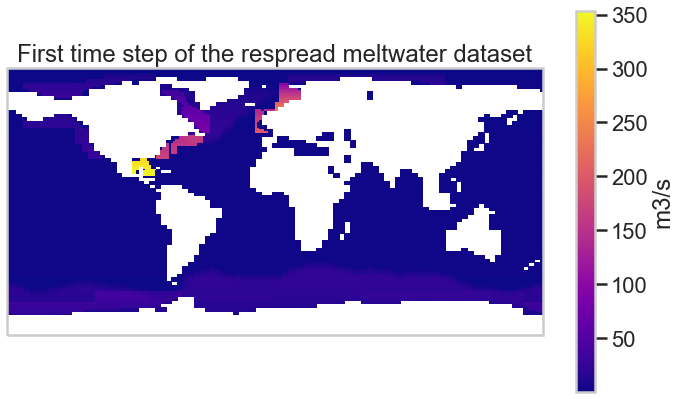

In [35]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(12,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, tb.masking(ds_spread_out.discharge[0], lsm_ice6g), 
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("First time step of the respread meltwater dataset")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

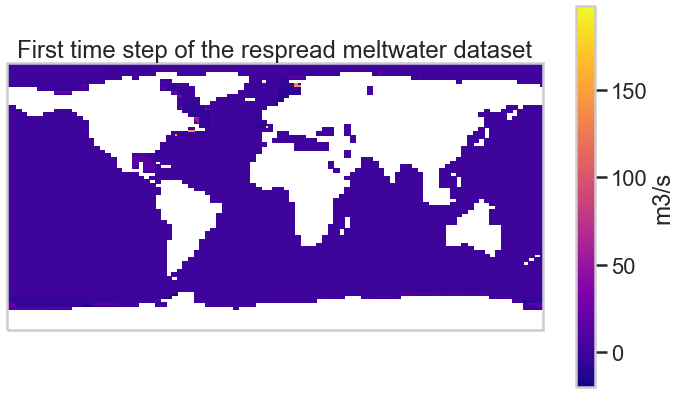

In [36]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(12,7))

discharge_change = (ds_spread_out.discharge[0]-wfix_ice6g_3d[0]).values - (ds_spread_ini.discharge[0]-wfix_glac_3d[0]).values

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(lon_hadcm3_b, lat_hadcm3_b, tb.masking(discharge_change, lsm_ice6g), 
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("First time step of the respread meltwater dataset")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

In [37]:
# We can save this intermediate output as data for the other demonstration notebooks.

# ds_spread_out.to_netcdf(f"{script_folder}/outputs/sample_respread_discharge.nc")